# Survival Analysis of Patients Living with Primary Biliary Cirrhosis

### Introduction



This dataset was downloaded from kaggle website. Its a 10 year dataset collected from a Mayo Clinic study on primary biliary cirrhosis of the liver between 1974 and 1984.
This analysis aims to determine the average survival time  and also build a cox model to predict survival in patients with Primary Biliary Cirrhosis

##### Load and explore dataset

In [3]:
#import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, proportional_hazard_test
from lifelines.utils import median_survival_times, concordance_index
from lifelines.plotting import add_at_risk_counts
import warnings
warnings.filterwarnings('ignore')
print('Libraries Imported')

Libraries Imported


In [4]:
#import dataset

df1 = pd.read_csv(r"C:\Users\hassa\Downloads\Portfolio datasets\Old\cirrhosis.csv")
print('Dataset successfully imported')

Dataset successfully imported


In [5]:
#create a copy of the dataset
df = df1.copy()

In [6]:
#overview of top 5 rows in the dataset

df.head(5)

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [7]:
#number of rows and columns of the dataset

df.shape

(418, 20)

In [8]:
#overview of the variables in the dataset

df.columns

Index(['ID', 'N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites',
       'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol',
       'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets',
       'Prothrombin', 'Stage'],
      dtype='object')

In [9]:
#check for data types

df.dtypes

ID                 int64
N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object

In [10]:
#drop unnecessary columns

df.drop(columns =['ID'], inplace=True)

In [11]:
#is there any missing value

df.isnull().sum().any()

True

In [12]:
#are there any duplicates

df.duplicated().any()

False

In [13]:
#summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage     

##### Data Preprocessing

In [14]:
#change the data type of stage column

df['Stage'] = df['Stage'].astype('category')

In [15]:
#checking for outliers

outliers_df = []

for col in df.select_dtypes(include = ['float64', 'int64']).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_no = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    outliers_df.append([col, lower_bound, upper_bound, outliers_no])
    outliers_table = pd.DataFrame(outliers_df, columns = ['Column Name', 'Lowerbound', 'Upperbound', 'No of Outliers']).sort_values('No of Outliers', ascending = False)
    
outliers_table

,Column Name,Lowerbound,Upperbound,No of Outliers
2,Bilirubin,-3.10000,7.30000,46
6,Alk_Phos,-791.25000,3642.75000,35
3,Cholesterol,23.75000,625.75000,20
10,Prothrombin,8.35000,12.75000,18
5,Copper,-81.37500,245.62500,17
8,Tryglicerides,-15.87500,251.12500,10
4,Albumin,2.45125,4.56125,9
7,SGOT,-26.35000,258.85000,7
9,Platelets,-5.75000,512.25000,6
0,N_Days,-1188.37500,4894.62500,0


In [16]:
#let us have a look at the statistical summary of numerical variables

df.describe(include = 'number').T

,count,mean,std,min,25%,50%,75%,max
N_Days,418.0,1917.782297,1104.672992,41.00,1092.7500,1730.00,2613.50,4795.00
Age,418.0,18533.351675,3815.845055,9598.00,15644.5000,18628.00,21272.50,28650.00
Bilirubin,418.0,3.220813,4.407506,0.30,0.8000,1.40,3.40,28.00
Cholesterol,284.0,369.510563,231.944545,120.00,249.5000,309.50,400.00,1775.00
Albumin,418.0,3.497440,0.424972,1.96,3.2425,3.53,3.77,4.64
Copper,310.0,97.648387,85.613920,4.00,41.2500,73.00,123.00,588.00
Alk_Phos,312.0,1982.655769,2140.388824,289.00,871.5000,1259.00,1980.00,13862.40
SGOT,312.0,122.556346,56.699525,26.35,80.6000,114.70,151.90,457.25
Tryglicerides,282.0,124.702128,65.148639,33.00,84.2500,108.00,151.00,598.00
Platelets,407.0,257.024570,98.325585,62.00,188.5000,251.00,318.00,721.00


We will not tamper with the outliers. They are possible values in some special cases

In [17]:
#summary of missing values


def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_perc = mis_val/len(df) *100
    mis_val_table = pd.DataFrame({'missing values' : mis_val, '% of Total Values': mis_val_perc}).sort_values('% of Total Values', ascending = False).round (2)
    mis_val_table = mis_val_table[mis_val_table['missing values'] != 0]
    return mis_val_table
missing_values_table(df)

,missing values,% of Total Values
Tryglicerides,136,32.54
Cholesterol,134,32.06
Copper,108,25.84
Drug,106,25.36
Ascites,106,25.36
Hepatomegaly,106,25.36
Spiders,106,25.36
SGOT,106,25.36
Alk_Phos,106,25.36
Platelets,11,2.63


In [18]:
#convert censoring to binary 

df['event'] = df['Status'].apply(lambda x:1 if x == 'D' else 0)

In [19]:
#identifying time variable

df['Time'] = df['N_Days']

In [20]:
#its time to drop unnecessary columns

df.drop(columns =['N_Days', 'Status'], inplace = True)

In [21]:
#we now have our cleaned dataset ready for analysis


df.head()

,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,event,Time
0,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0,1,400
1,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0,0,4500
2,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0,1,1012
3,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0,1,1925
4,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0,0,1504


##### Data Visualization

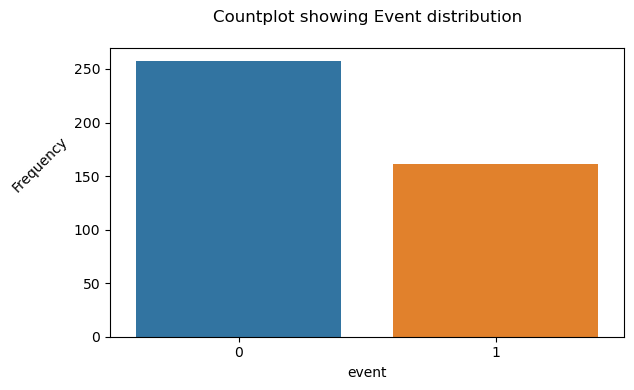

In [22]:
#distribution of event

plt.figure(figsize = (6,4))
sns.countplot(x = df['event'])
plt.title('Countplot showing Event distribution\n')
plt.tight_layout()
plt.ylabel('Frequency\n\n', rotation =45)
plt.show()

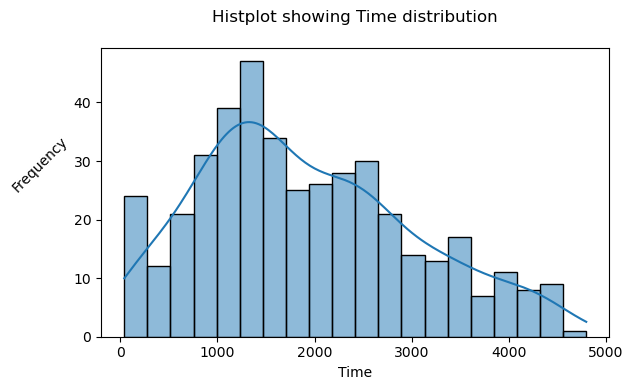

In [23]:
#distribution of Survival Time

plt.figure(figsize = (6,4))
sns.histplot(x = df['Time'], bins = 20, kde = True)
plt.title('Histplot showing Time distribution\n')
plt.tight_layout()
plt.ylabel('Frequency\n\n', rotation =45)
plt.show()

##### Kaplan Meier Survival Analysis

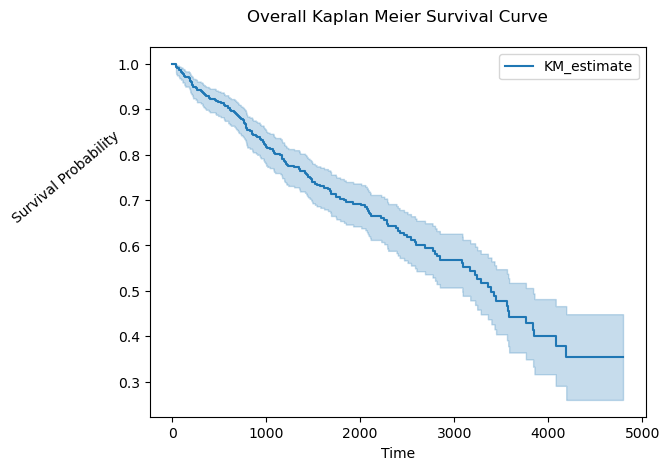

In [24]:
#Overall survival curve

kmf = KaplanMeierFitter()
kmf.fit(durations = df['Time'], event_observed = df['event'])
kmf.plot_survival_function()
plt.title('Overall Kaplan Meier Survival Curve\n')
plt.ylabel('Survival Probability\n\n\n\n', rotation = 40)
plt.xlabel('Time')
plt.show()

Text(0.5, 1.0, 'Failure curve')

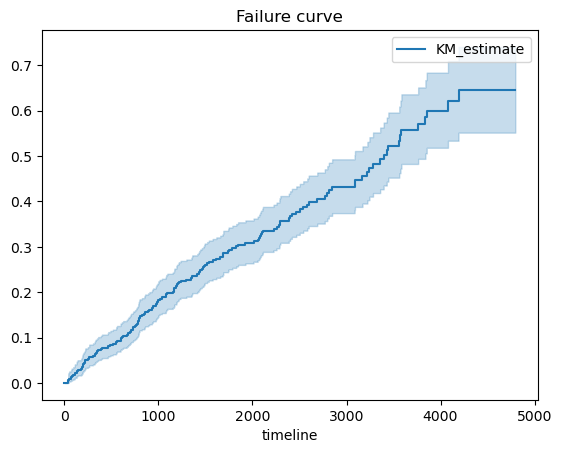

In [25]:
#lets plot the failure curve

kmf.plot_cumulative_density()
plt.title('Failure curve')

In [26]:
#lets estimate the median survival time and 95% confidence interval

median = kmf.median_survival_time_
median_confidence_interval = median_survival_times(kmf.confidence_interval_)

print(median)
print(median_confidence_interval)

3395.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                  3086.0                  3839.0


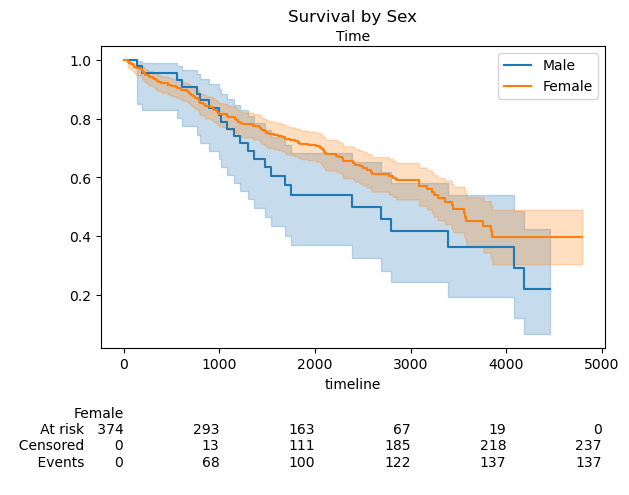

In [27]:
#survival by sex

fig, ax = plt.subplots()
m = df['Sex'] == 'M'
kmf.fit(durations = df['Time'][m], event_observed = df['event'][m], label = 'Male')
kmf.plot_survival_function(ax=ax)
kmf.fit(durations = df['Time'][~m], event_observed = df['event'][~m], label = 'Female')
kmf.plot_survival_function(ax=ax, at_risk_counts = True)
plt.title('Survival by Sex')
plt.ylabel('Survival Probability\n\n\n', rotation = 40)
plt.xlabel('Time')
plt.show()

In [28]:
#log rank test of sex

results = logrank_test(
        df[df['Sex'] == 'M']['Time'],
        df[df['Sex'] == 'F']['Time'],
        event_observed_A= df[df['Sex'] == 'M']['event'],
        event_observed_B= df[df['Sex'] == 'F']['event'])
   
print("\nLog-Rank Test for Sex ")
results.print_summary()
round(results.p_value, 4)


Log-Rank Test for Sex 


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.98 0.08      3.57

0.0845

There is no statistically significant difference in survival between males and females (p-value = 0.08)

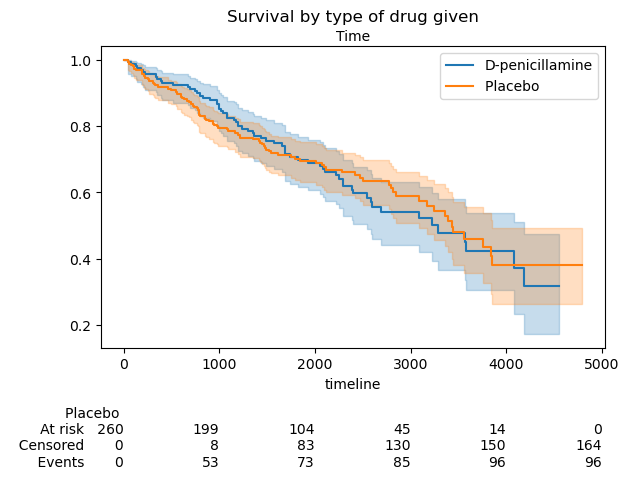

In [29]:
#survival by drug given

fig, ax = plt.subplots()
d = df['Drug'] == 'D-penicillamine'
kmf.fit(durations = df['Time'][d], event_observed = df['event'][d], label = 'D-penicillamine')
kmf.plot_survival_function(ax=ax)
kmf.fit(durations = df['Time'][~d], event_observed = df['event'][~d], label = 'Placebo ')
kmf.plot_survival_function(ax=ax, at_risk_counts = True)
plt.title('Survival by type of drug given')
plt.ylabel('Survival Probability\n\n\n', rotation = 40)
plt.xlabel('Time')
plt.show()

In [30]:
#log rank test of Drug given

results = logrank_test(
        df[df['Drug'] == 'D-penicillamine']['Time'],
        df[df['Drug'] == 'Placebo']['Time'],
        event_observed_A= df[df['Drug'] == 'D-penicillamine']['event'],
        event_observed_B= df[df['Drug'] == 'Placebo']['event'])
   
print("\nLog-Rank Test for Drug given ")
results.print_summary()
round(results.p_value, 4)


Log-Rank Test for Drug given 


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.10 0.75      0.42

0.7498

There is no statistically significant difference in survival between use of D-penicillamine and placebo (p-value = 0.75)

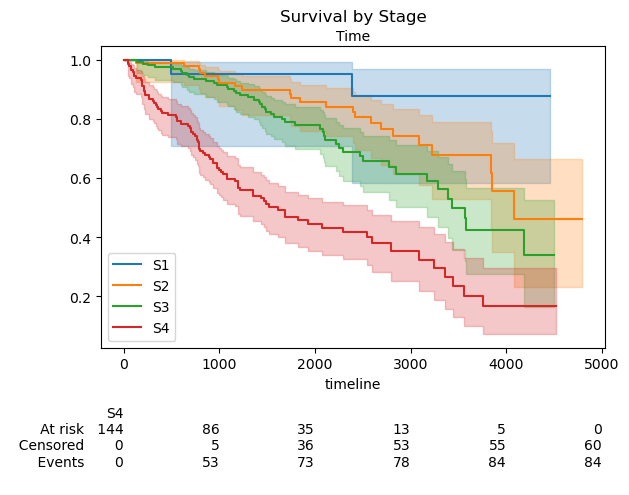

In [31]:
#survival by disease stage

km_df = df[['Time', 'event', 'Stage']].dropna()
fig, ax = plt.subplots()
S1 = km_df['Stage'] == 1
S2 = km_df['Stage'] == 2
S3 = km_df['Stage'] == 3
S4 = km_df['Stage'] == 4
kmf.fit(durations = km_df['Time'][S1], event_observed = km_df['event'][S1], label = 'S1')
kmf.plot_survival_function(ax=ax)
kmf.fit(durations = km_df['Time'][S2], event_observed = km_df['event'][S2], label = 'S2')
kmf.plot_survival_function(ax=ax)
kmf.fit(durations = km_df['Time'][S3], event_observed = km_df['event'][S3], label = 'S3')
kmf.plot_survival_function(ax=ax)
kmf.fit(durations = km_df['Time'][S4], event_observed = km_df['event'][S4], label = 'S4')
kmf.plot_survival_function(ax=ax, at_risk_counts = True)
plt.title('Survival by Stage')
plt.ylabel('Survival Probability\n\n\n', rotation = 40)
plt.xlabel('Time')
plt.show()

In [32]:
#log rank test of stage

stages = sorted(km_df['Stage'].unique())
if len(stages) > 1:
    print("\nPairwise Log-Rank Tests for Stage")
    for i in range(len(stages)):
        for j in range(i+1, len(stages)):
            group1 = km_df[km_df['Stage'] == stages[i]]
            group2 = km_df[km_df['Stage'] == stages[j]]
            
            results = logrank_test(group1['Time'],
                    group2['Time'],
                    event_observed_A=group1['event'],
                    event_observed_B=group2['event'])
            print(f"\nStage {stages[i]} vs Stage {stages[j]}:")
            print(results.p_value)
            results.print_summary()


Pairwise Log-Rank Tests for Stage

Stage 1.0 vs Stage 2.0:
0.10637862699099203


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.61 0.11      3.23


Stage 1.0 vs Stage 3.0:
0.015080327494350771


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.91 0.02      6.05


Stage 1.0 vs Stage 4.0:
3.069872860106513e-05


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          17.37 <0.005     14.99


Stage 2.0 vs Stage 3.0:
0.05576749050661122


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.66 0.06      4.16


Stage 2.0 vs Stage 4.0:
5.303920972145844e-10


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          38.56 <0.005     30.81


Stage 3.0 vs Stage 4.0:
1.2935730413197166e-08


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          32.34 <0.005     26.20

There is a significant statistical difference in survival between Stages 1 and 3 (p-value = 0.02), Stages 1 and 4 (p-value = <0.005), Stages 2 and 4 (p-value =<0.005, and Stages 3 and 4 (p-value = <0.005).

##### Cox proportional hazard model

In [33]:
#top rows of the dataset

df.head()

,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,event,Time
0,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0,1,400
1,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0,0,4500
2,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0,1,1012
3,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0,1,1925
4,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0,0,1504


In [34]:
#define the variables and split dataset

X = df.drop(columns=['Time', 'event'])
y = df[['Time', 'event']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [35]:
#numerical columns

num_col = df.select_dtypes(include = ['float64', 'int64']).columns
num_col

Index(['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'event', 'Time'],
      dtype='object')

In [36]:
#categorical columns

cat_col = df.select_dtypes(include = ['object', 'category']).columns
cat_col

Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage'], dtype='object')

In [37]:
#we are removing time and event from the columns for processing of other variables

num_cols = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos','SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
cat_cols = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']

In [38]:
#impute missing values in numerical columns

num_imputer = SimpleImputer(strategy="median")
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_test[num_cols] = num_imputer.transform(X_test[num_cols])


In [39]:
# #impute missing values in Categorical columns
cat_imputer = SimpleImputer(strategy="most_frequent")
X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])
X_test[cat_cols] = cat_imputer.transform(X_test[cat_cols])

In [40]:
#one-hot encode categorical variables
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

In [41]:
#Scale numerical variables
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [42]:
#combine all train set

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
train_df = pd.concat([X_train, y_train], axis=1)

In [43]:
#combine test set

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1)

In [44]:
#Fit Cox model
cph = CoxPHFitter()  
cph.fit(train_df, duration_col='Time', event_col='event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 292 total observations, 184 right-censored observations>
             duration col = 'Time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 292
number of events observed = 108
   partial log-likelihood = -471.48
         time fit was run = 2025-07-04 16:48:52 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
Age             0.18      1.20      0.11           -0.04            0.40                0.97                1.49
Bilirubin       0.39      1.47      0.11            0.18            0.60                1.20                1.82
Cholesterol     0.14      1.15      0.09           -0.04            0.31                0.96                1.36
Albumin        -0.30      0.74      0.12           -0.53           -0.07                0.59                0.94
Copper          0.21      1.24      0.10            0.01            0.41                1.01                1.51
Alk_Phos        0.04      1.04      0.09           -0.13            0.20                0.88                1.23
SGOT            0.10      1.11      0.12           -0.12            0.33                0.89                1.39
Tryglicerides  -0.13      0.88      0.09           -0.31            0.05                0.74                1.05
Platelets      -0.09      0.92      0.13           -0.33            0.16                0.72                1.17
Prothrombin     0.39      1.47      0.11            0.16            0.61                1.18                1.84
Drug_Placebo   -0.50      0.61      0.23           -0.96           -0.04                0.38                0.96
Sex_M          -0.14      0.87      0.32           -0.76            0.48                0.47                1.62
Ascites_Y       0.06      1.06      0.40           -0.72            0.84                0.48                2.32
Hepatomegaly_Y  0.29      1.34      0.26           -0.21            0.80                0.81                2.22
Spiders_Y      -0.68      0.51      0.29           -1.26           -0.11                0.28                0.90
Edema_S         0.24      1.28      0.30           -0.35            0.84                0.70                2.31
Edema_Y         0.86      2.35      0.41            0.06            1.65                1.06                5.21
Stage_2.0       0.69      2.00      0.82           -0.91            2.29                0.40                9.88
Stage_3.0       0.91      2.48      0.80           -0.67            2.49                0.51               12.01
Stage_4.0       1.57      4.83      0.79            0.02            3.13                1.02               22.78

                cmp to     z      p  -log2(p)
covariate                                    
Age               0.00  1.64   0.10      3.32
Bilirubin         0.00  3.65 <0.005     11.88
Cholesterol       0.00  1.54   0.12      3.03
Albumin           0.00 -2.52   0.01      6.40
Copper            0.00  2.10   0.04      4.81
Alk_Phos          0.00  0.43   0.67      0.58
SGOT              0.00  0.90   0.37      1.45
Tryglicerides     0.00 -1.38   0.17      2.57
Platelets         0.00 -0.70   0.49      1.04
Prothrombin       0.00  3.40 <0.005     10.56
Drug_Placebo      0.00 -2.12   0.03      4.87
Sex_M             0.00 -0.43   0.67      0.59
Ascites_Y         0.00  0.15   0.88      0.18
Hepatomegaly_Y    0.00  1.15   0.25      1.99
Spiders_Y         0.00 -2.33   0.02      5.64
Edema_S           0.00  0.80   0.42      1.24
Edema_Y           0.00  2.11   0.03      4.84
Stage_2.0         0.00  0.85   0.40      1.34
Stage_3.0         0.00  1.13   0.26      1.96
Stage_4.0         0.00  1.99   0.05      4.42
---
Concordance = 0.82
Partial AIC = 982.97
log-likelihood ratio test = 145.59 on 20 df
-log2(p) of ll-ratio test = 67.63

In [45]:
#determine concordance index

risk_scores = -cph.predict_partial_hazard(test_df)
c_index = concordance_index(test_df['Time'], risk_scores, test_df['event'])
print(f"C-index: {c_index:.3f}")

C-index: 0.817


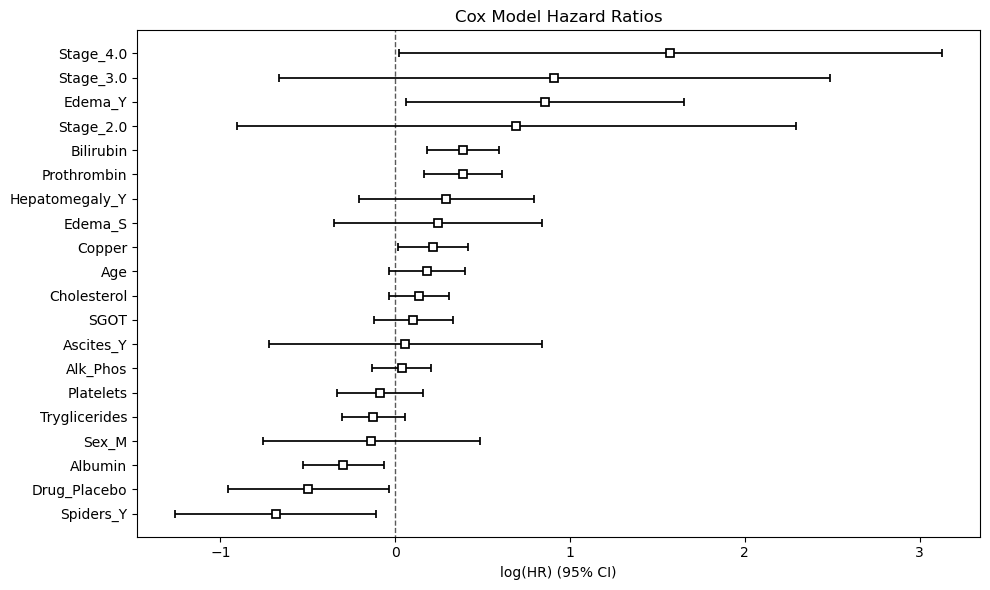

In [46]:
# Plot coefficients

plt.figure(figsize=(10, 6))
cph.plot()
plt.title('Cox Model Hazard Ratios')
plt.tight_layout()
plt.show()

In [47]:
# Check proportional hazards assumption

cph.check_assumptions(train_df, p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 292 total observations, 184 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic    p  -log2(p)
Age            km              0.79 0.37      1.42
               rank            0.55 0.46      1.12
Albumin        km              0.08 0.78      0.36
               rank            0.54 0.46      1.11
Alk_Phos       km              0.46 0.50      1.01
               rank            1.45 0.23      2.13
Ascites_Y      km              0.02 0.89      0.17
               rank            0.05 0.82      0.29
Bilirubin      km              0.00 0.95      0.08
               rank            0.13 0.72      0.47
Cholesterol    km              0.59 0.44      1.18
               rank            1.22 0.27      1.90
Copper         km              2.04 0.15      2.70
               rank            2.68 0.10      3.30
Drug_Placebo   km              0.12 0.73      0.46
               rank            0.50 0.48      1.06
Edema_S        km              0.14 0.71      0.49
               rank            0.16 0.69      0.54
Edema_Y        km              0.33 0.57      0.82
               rank            0.34 0.56      0.83
Hepatomegaly_Y km              3.04 0.08      3.62
               rank            2.49 0.11      3.12
Platelets      km              0.00 0.98      0.03
               rank            0.00 0.97      0.04
Prothrombin    km              2.77 0.10      3.38
               rank            4.86 0.03      5.19
SGOT           km              0.23 0.63      0.66
               rank            0.03 0.86      0.22
Sex_M          km              0.24 0.63      0.68
               rank            0.73 0.39      1.35
Spiders_Y      km              1.87 0.17      2.54
               rank            3.24 0.07      3.80
Stage_2.0      km              0.00 0.95      0.08
               rank            0.03 0.86      0.22
Stage_3.0      km              0.23 0.63      0.67
               rank            0.41 0.52      0.94
Stage_4.0      km              0.27 0.60      0.73
               rank            0.58 0.45      1.17
Tryglicerides  km              1.00 0.32      1.66
               rank            0.73 0.39      1.35



1. Variable 'Prothrombin' failed the non-proportional test: p-value is 0.0274.

   Advice 1: the functional form of the variable 'Prothrombin' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Prothrombin' using pd.cut, and then specify it in
`strata=['Prothrombin', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assu

[]

Prothrombin failed the non proportional test. Lets fix this

In [48]:
#we have to bin prothrombin variable
train_df['Prothrombin_bin'] = pd.cut(train_df['Prothrombin'], bins=3)

In [49]:
#fit the model

cox = CoxPHFitter() 
cox.fit(train_df, duration_col='Time', event_col='event', strata=['Prothrombin_bin'])
cox.print_summary()

<lifelines.CoxPHFitter: fitted with 292 total observations, 184 right-censored observations>
             duration col = 'Time'
                event col = 'event'
                   strata = Prothrombin_bin
      baseline estimation = breslow
   number of observations = 292
number of events observed = 108
   partial log-likelihood = -413.01
         time fit was run = 2025-07-04 16:48:56 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
Age             0.20      1.22      0.11           -0.03            0.42                0.97                1.52
Bilirubin       0.35      1.42      0.11            0.13            0.57                1.14                1.77
Cholesterol     0.16      1.18      0.09           -0.01            0.34                0.99                1.40
Albumin        -0.35      0.71      0.12           -0.58           -0.11                0.56                0.90
Copper          0.22      1.24      0.10            0.01            0.42                1.01                1.52
Alk_Phos        0.03      1.03      0.08           -0.13            0.20                0.87                1.22
SGOT            0.10      1.10      0.12           -0.14            0.33                0.87                1.40
Tryglicerides  -0.12      0.89      0.10           -0.31            0.07                0.74                1.08
Platelets      -0.07      0.93      0.13           -0.32            0.17                0.73                1.19
Prothrombin     0.54      1.71      0.20            0.14            0.94                1.15                2.55
Drug_Placebo   -0.40      0.67      0.24           -0.87            0.07                0.42                1.07
Sex_M          -0.12      0.89      0.32           -0.75            0.50                0.47                1.66
Ascites_Y       0.08      1.08      0.41           -0.73            0.89                0.48                2.44
Hepatomegaly_Y  0.22      1.24      0.26           -0.30            0.73                0.74                2.08
Spiders_Y      -0.78      0.46      0.30           -1.37           -0.18                0.25                0.83
Edema_S         0.23      1.26      0.32           -0.40            0.87                0.67                2.38
Edema_Y         0.61      1.84      0.43           -0.23            1.44                0.80                4.23
Stage_2.0       0.10      1.11      0.77           -1.40            1.61                0.25                4.98
Stage_3.0       0.37      1.45      0.76           -1.11            1.86                0.33                6.43
Stage_4.0       0.96      2.61      0.78           -0.57            2.49                0.57               12.01

                cmp to     z      p  -log2(p)
covariate                                    
Age               0.00  1.71   0.09      3.52
Bilirubin         0.00  3.09 <0.005      8.95
Cholesterol       0.00  1.81   0.07      3.82
Albumin           0.00 -2.88 <0.005      7.96
Copper            0.00  2.06   0.04      4.66
Alk_Phos          0.00  0.38   0.70      0.51
SGOT              0.00  0.81   0.42      1.26
Tryglicerides     0.00 -1.20   0.23      2.12
Platelets         0.00 -0.57   0.57      0.82
Prothrombin       0.00  2.64   0.01      6.91
Drug_Placebo      0.00 -1.68   0.09      3.43
Sex_M             0.00 -0.38   0.70      0.51
Ascites_Y         0.00  0.19   0.85      0.24
Hepatomegaly_Y    0.00  0.82   0.41      1.29
Spiders_Y         0.00 -2.56   0.01      6.58
Edema_S           0.00  0.72   0.47      1.09
Edema_Y           0.00  1.43   0.15      2.70
Stage_2.0         0.00  0.14   0.89      0.16
Stage_3.0         0.00  0.49   0.62      0.68
Stage_4.0         0.00  1.23   0.22      2.20
---
Concordance = 0.79
Partial AIC = 866.02
log-likelihood ratio test = 106.25 on 20 df
-log2(p) of 

In [50]:
#determine concordance index

risk_scores = -cox.predict_partial_hazard(test_df)
c_index = concordance_index(test_df['Time'], risk_scores, test_df['event'])
print(f"C-index: {c_index:.3f}")

C-index: 0.808


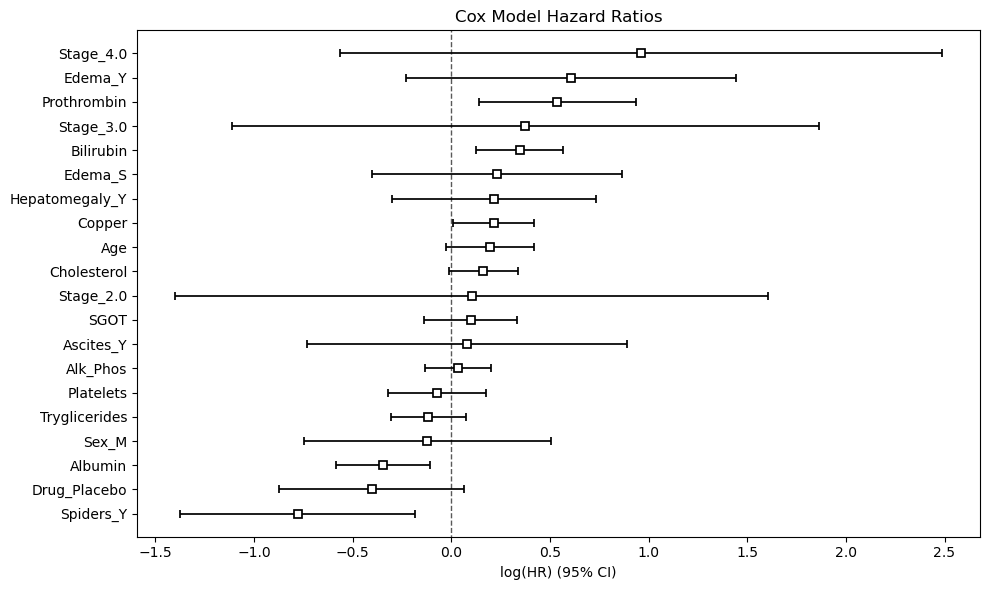

In [51]:
#plot hazard ratios

plt.figure(figsize=(10, 6))
cox.plot()
plt.title('Cox Model Hazard Ratios')
plt.tight_layout()
plt.show()

In [52]:
#check assumptions

cox.check_assumptions(train_df, p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 292 total observations, 184 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic    p  -log2(p)
Age            km              0.28 0.60      0.74
               rank            0.24 0.62      0.68
Albumin        km              0.17 0.68      0.56
               rank            0.85 0.36      1.49
Alk_Phos       km              1.27 0.26      1.95
               rank            0.38 0.54      0.90
Ascites_Y      km              0.01 0.92      0.11
               rank            0.17 0.68      0.55
Bilirubin      km              0.02 0.89      0.17
               rank            0.15 0.70      0.52
Cholesterol    km              0.58 0.45      1.16
               rank            0.01 0.91      0.14
Copper         km              2.05 0.15      2.71
               rank            0.76 0.38      1.38
Drug_Placebo   km              0.21 0.65      0.63
               rank            0.07 0.80      0.33
Edema_S        km              0.69 0.41      1.30
               rank            4.58 0.03      4.95
Edema_Y        km              0.25 0.62      0.69
               rank            0.98 0.32      1.64
Hepatomegaly_Y km              3.25 0.07      3.81
               rank            1.16 0.28      1.83
Platelets      km              0.25 0.62      0.70
               rank            0.36 0.55      0.86
Prothrombin    km              1.44 0.23      2.12
               rank            1.06 0.30      1.72
SGOT           km              0.14 0.71      0.50
               rank            1.48 0.22      2.16
Sex_M          km              0.72 0.40      1.34
               rank            1.30 0.25      1.98
Spiders_Y      km              1.25 0.26      1.93
               rank            0.18 0.67      0.57
Stage_2.0      km              0.39 0.53      0.91
               rank            0.31 0.58      0.79
Stage_3.0      km              0.00 0.95      0.08
               rank            0.04 0.84      0.25
Stage_4.0      km              0.11 0.74      0.43
               rank            0.09 0.76      0.39
Tryglicerides  km              1.59 0.21      2.27
               rank            2.86 0.09      3.46



1. Variable 'Edema_S' failed the non-proportional test: p-value is 0.0323.

   Advice: with so few unique values (only 2), you can include `strata=['Edema_S', ...]` in the call
in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[]

Edema _S also fails the assumption test. We will select top 8 predictors for our model to see if the assumption test will be satisfied

In [53]:
#determine top 8 predictors

p_values = {}
for col in X_train.columns:
    try:
        temp = train_df[[col, 'Time', 'event']].dropna()
        cph_temp = CoxPHFitter()
        cph_temp.fit(temp, duration_col='Time', event_col='event')
        p_values[col] = cph_temp.summary.loc[col, 'p']
    except:
        pass
    
top_8_df = pd.DataFrame(p_values.items(), columns=['Variable', 'p_value']).sort_values('p_value').head(8)
print("📊 Top 8 predictors by p-value:\n")
print(top_8_df)

top_8 = top_8_df['Variable'].tolist()


📊 Top 8 predictors by p-value:

       Variable       p_value
1     Bilirubin  5.244249e-19
9   Prothrombin  1.024985e-11
3       Albumin  1.799203e-11
19    Stage_4.0  3.058476e-11
12    Ascites_Y  3.160120e-10
16      Edema_Y  1.413533e-08
4        Copper  6.834349e-07
6          SGOT  2.134501e-06


In [54]:
#fit new model

final_train_df = train_df[top_8 + ['Time', 'event']]
final_train_df['Prothrombin_bin'] = pd.cut(final_train_df['Prothrombin'], bins=3)
coxph = CoxPHFitter()
coxph.fit(final_train_df, duration_col='Time', event_col='event', strata=['Prothrombin_bin', 'Stage_4.0'])
coxph.print_summary()


<lifelines.CoxPHFitter: fitted with 292 total observations, 184 right-censored observations>
             duration col = 'Time'
                event col = 'event'
                   strata = ['Prothrombin_bin', 'Stage_4.0']
      baseline estimation = breslow
   number of observations = 292
number of events observed = 108
   partial log-likelihood = -363.63
         time fit was run = 2025-07-04 16:48:59 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
Bilirubin    0.32      1.38      0.10            0.13            0.51                1.14                1.67
Prothrombin  0.44      1.56      0.19            0.06            0.82                1.07                2.27
Albumin     -0.35      0.70      0.12           -0.58           -0.12                0.56                0.89
Ascites_Y   -0.03      0.97      0.39           -0.79            0.72                0.45                2.06
Edema_Y      0.29      1.33      0.39           -0.48            1.05                0.62                2.86
Copper       0.18      1.20      0.09            0.01            0.36                1.01                1.43
SGOT         0.04      1.04      0.11           -0.17            0.24                0.84                1.27

             cmp to     z      p  -log2(p)
covariate                                 
Bilirubin      0.00  3.31 <0.005     10.05
Prothrombin    0.00  2.29   0.02      5.50
Albumin        0.00 -2.99 <0.005      8.50
Ascites_Y      0.00 -0.09   0.93      0.10
Edema_Y        0.00  0.73   0.46      1.11
Copper         0.00  2.03   0.04      4.56
SGOT           0.00  0.34   0.74      0.44
---
Concordance = 0.72
Partial AIC = 741.25
log-likelihood ratio test = 53.17 on 7 df
-log2(p) of ll-ratio test = 28.12

In [55]:
#check for assumptions

coxph.check_assumptions(final_train_df, p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

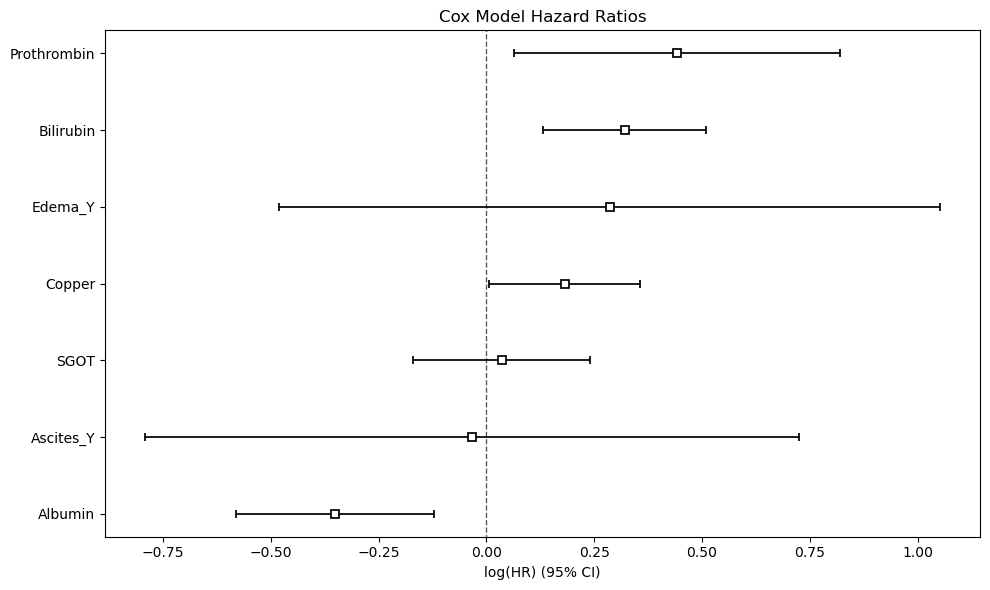

In [56]:
# Let's Plot coefficients

plt.figure(figsize=(10, 6))
coxph.plot()
plt.title('Cox Model Hazard Ratios')
plt.tight_layout()
plt.show()

In [57]:
#determine c- index

risk_scores = -coxph.predict_partial_hazard(test_df)
c_index = concordance_index(test_df['Time'], risk_scores, test_df['event'])
print(f"C-index: {c_index:.3f}")

C-index: 0.819


In [58]:
# Save the model for future use
import joblib
joblib.dump(coxph, 'liver_cirrhosis_cox_model.pkl')
print('Complete')

Complete


#### Conclusion

A multivariable Cox model was built with 8 significant predictors, and stratified on Prothrombin_bin and Stage_4 to satisfy the proportional hazards assumption. The final model achieved a C-index of 0.82 on the test set.